## There are four complementary techniques that can be used to speed up the predictions and reduce the memory footprint of your transformer models
- knowledge distillation
- quatization
- pruning
- graph optimization with Open Neutral Network Exchange(ONNX) fromat and ONNX runtime (ORT)



- We will also seee how some of these techniques can be combined to produce significant performance gains.

## Intent Detection as a Case Study

- Lets say we build a text-based assitant for out company's call center so that customers can request their accunt balance or make bookings without needing to speak with a human agent

- In order to understand the goals of a customer, our assistant will need to be able to classify a wide variety of natural language text into a set of predifned actions or intents

- To be a robust production environment our classifier will also need to be able to handle out-of-scope queries, where a customer makes a query that doesn't belong to any of the predefined intents and the system should yield a fallback response

In [2]:
!pip install transformers accelerate sentencepiece datasets -q

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from transformers import pipeline

bert_ckpt="transformersbook/bert-base-uncased-finetuned-clinc"
pipe=pipeline('text-classification',model=bert_ckpt)

In [6]:
query="""Hey, I'd like to to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""

pipe(query)

[{'label': 'car_rental', 'score': 0.5505122542381287}]

## Creating a Performance Benchmark

**Model Performance**
    - How well does our model perform on a well crafted test set that reflect production data? This is especially important when the cost of making errors is large (and best mitigated with a human in the loop), or when  we need to run inference on millions of examples and small improvements to the model metrics can translate into larger gains in aggregate

**Latency**
    - How fast can our model deliver predictions? We usually care about latency in real-time environments that deal with a lot of traffic, like how Stack Overflow needed a classifier to quickly detect unwelcome comments on the website

**Memory**
    - How can we deploy billion-parameter models lik GPT-2 or T5 that require gb of disk storage and RAM? Memory plays an especially important role in mobile or edge devices, where a model has to generate predictions without access to a powerful cloud server




In [7]:
class PerformanceBenchmark:
    def __init__(self,pipeline,dataset,optim_type='BERT baseline'):
        self.pipeline=pipeline
        self.dataset=dataset
        self.optim_type=optim_type

    def compute_accuracy(self):
        """"""
        pass
    def compute_size(self):
        pass
    def time_pipeline(sef):
        pass
    def run_benchmark(self):
        metrics={}
        metrics[self.optim_type]=self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

- We've defined an optim_type parameter to keep track of the different optimization techniques.

- We use run_benchmark() method to collect all the metrics in a dictionary, with keys given by optim_type



In [8]:
from datasets import load_dataset

clinc=load_dataset("clinc_oos","plus")


In [9]:
sample=clinc['test'][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [10]:
 intents=clinc['test'].features['intent']
 intents.int2str(sample['intent'])

'transfer'

In [11]:
from datasets import load_metric
accuracy_score=load_metric('accuracy')

<ipython-input-11-c3025047c7ff>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score=load_metric('accuracy')


- The accuracy metric expects the predictions and references to be integers
- We can use the pipleine to extract the predictions from the text field and the use the str2int() method of our intents object to map each prediction to its corresponding ID.

- The following code collects all the predictions and labels in the lists before returning the accuracy on the dataset.

In [12]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method """
    preds,labels=[],[]
    for example in self.dataset:
        pred=self.pipeline(example['text'])[0]['label']
        label=example['intent']
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy=accuracy_score.compute(predictions=preds,references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy=compute_accuracy

- Now lets compute the size of our model using the torch.save() function from PyTorch to serialize the model to disk.
- Under the hood, torch.save() uses Python's pickle module and can be used to sabe anything from models to tensors to ordinary python objets.
- In PyTorch, the recommended way to save a model is by using its state_dict, which is a Python dictioanry that maps each layer in a model to its leanable parameters (weights, and biases)

- Lets see what is stored in the state_dict of our baseline model:


In [11]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

- We can see that each key/value pair corresponds to a specifc lyer and tensor in BERT, so if we save our model with:


In [12]:
import torch
torch.save(pipe.model.state_dict(),'model.pt')

- We can then use `Path.stat()` function from Pythons' pathlib module to get information about the underlying files.

- In particular, `Path('model.pt').stat().st_size()` will giveus the model size in bytes

In [13]:
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method """
    state_dict=self.pipeline.model.state_dict()
    tmp_path=Path('model.pt')
    torch.save(state_dict,tmp_path)
    # Calculate size in megabytes
    size_mb=Path(tmp_path).stat().st_size/(1024*1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"MOdel size (MB)- {size_mb:.2f}")
    return {"size_mb":size_mb}

PerformanceBenchmark.compute_size=compute_size

- Lets implement the `time_pipeline()` function so that we can time the average latency per query. For this applciation, latency refers to the time it takes to feed q text query to the pipeline and return the predicted intent from the model

- Under the hood the pipeline also tokenizes the text, but this is around one thousand times faster than generating the predictions and thus adda neglible contribution to the overall latency

- A simple way to measure the executin time of a code snippet is to use the perf_counter() function from Python time module. This function has a better time resolution that the time.time() function is well suited for getting precise results

In [14]:
from time  import perf_counter

for _ in range(3):
    start_time=perf_counter()
    _=pipe(query)
    latency=perf_counter()-start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")


Latency (ms) - 28.946
Latency (ms) - 27.154
Latency (ms) - 26.757


- Resuls exhibit some spread in the latencies and suggests that timing a single pass through the pipeline can give wildly different results each time we run the code.

- So , we collect the latencies over many runs and then use the resulting distribution to calculate the mean and standard deviation, which will give us an idea about the spread values.

- The following code does what we need and includes a phase to warm up the CPU before performing the actual timed run:

In [15]:
import numpy as np

def time_pipeline(self,query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method """
    latencies=[]

    #Warmup
    for _ in range(10):
        _=self.pipeline(query)
    #Timed run
    for _ in range(100):
        start_time=perf_counter()
        _=self.pipeline(query)
        latency=perf_counter() - start_time
        latencies.append(latency)
    #Compute run statistics

    time_avg_ms=1000*np.mean(latencies)
    time_std_ms=1000*np.std(latencies)

    print(f"Average latnecy(ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {'time_avg_ms':time_avg_ms,"time_std_ms":time_std_ms}

PerformanceBenchmark.time_pipeline=time_pipeline


In [26]:
pb=PerformanceBenchmark(pipe,clinc['test'])
perf_metrics=pb.run_benchmark()

MOdel size (MB)- 132.39
Average latnecy(ms) - 9.10 +\- 0.61
Accuracy on test set - 0.876


## Making Models Smaller via Knowledge Distillation

- Knowledge distillation is a general purpose method for training a smaller student model to mimic the behavior of a slower,larger,but better-performing teacher.


## Knowledge Distillation for Fine-Tuning

- For supervised tasks like fine-tuning, the main idea is to augment the ground truth labels with a distriu=bution of "soft probabilities" from the teacher which provide complementary information for the student to learn from
- For example, if our BERt-base classifier assigns high probabilities to multiple intents, then this could be a sign that these intent s lie close to each other in the feature space.

- By training the student to mimic these probabilities, the goalis to distill some of this dark knowledge that the teacher has learned that is  knowledge that is not available from the labels alone


- Mathmematically the way it works is:

- Suppose we feed an input sequence to the teacher to generate a vector of logits z(x)=[z_1(x),.....,zₙ(x)]
   - We can covert these logits into probabilities by applying a softmax function:
   exp(zᵢ(x))/Σⱼexp(zⱼ(x))

   - This isn't quite what we want, because in many cases th teacher will asssign a high probability to one class, with all other class probabilities close to zero. When that happens, the teacher doesnt' provide much additional information beyond the ground truth labels, so instead we 'soften' the probabilities by scaling the logits with a temprature hyperparameter T before applying the softmax

      pᵢ(x)=exp(zᵢ(x)/T)/Σⱼexp(zⱼ(x)/T)

      - Higher T vlues produce a softer probability distributuion over the classes and teveal much more information about the decision boundary that the teacher has learned for each training example

      - T=1 we recover the orgiinal softmax distribution


Student also produces softened probabilities qᵢ(x) of its own, we can suse the Kullback-Leibler(KL) divergence to measure the difference between the two probability distributions

Dₖₗ(p,q)=Σᵢpᵢ(x)log(pᵢ(x)/qᵢ(x))


- With the KL divergence we can calculate how much is lost when we approximate the probability distribution of the teacher with the student. This allows us to define a knowledge distillation loss:

Lₖd=T^2Dₖₗ

where T^2 is a normalization factor to account for the fact that the magnitude of the gradients produced by soft labels scales as 1/T^2.

- For classification tasks, the student loss is then weighted average of the distillation loss with the usual cross-entropy loss L_CE of the ground truth labels:
L_student=αL_CE+(1-α)L_KD


where α is a hperparameter that controls the relative strength of each loss

- A diagram of the whole process is: The temperature is set to 1 at inference time to recover. the standard softmax probabilities

### Knowledge Distillation for Pretraining

- can be used during pretraining to create a general purpose student that can be subsequently fine-tuned on downstream tasks.
- In this case, th theacher is pretrained langauge model like BERT, which transfers it knowledge about masked language modelling to the student

- For example DistilBERT paper, the masked language modelling loss L_mlm is augmented with a term from knowledge diistillation and a cosine embedding loss l_cos=1-cos(hₛ,hₜ) to align th edirections of the hidden state vectors between the teacher and student:

L_DistilBERT=αL_mlm+βLₖd+ᵧLcos


## Creating a Knowledge Distillation Trainer

- We need to add a few things to the Trainer base class
    - The new hyperparameters α and T, which control the relative weight of the distillation loss and how muhc th eprobability distribution of the labels should be smoothed
    - The fine-tuned teacher model, which in our case is BERT-base
    - A new loss function that combines the cross-entropy loss with  the knowledge distillation loss


- Adding the new hyperparameters is quite simple, since  we just need to subclass TrainingArguments and include them as new attributes:

In [16]:
from transformers import TrainingArguments
from dataclasses import dataclass, field

@dataclass
class DistillationTrainingArguments(TrainingArguments):
    alpha: float = field(default=0.5, metadata={"help": "Distillation alpha hyperparameter."})
    temperature: float = field(default=2.0, metadata={"help": "Distillation temperature hyperparameter."})

    def __post_init__(self):
        super().__post_init__()


In [17]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss


- Lets unpack this code:
    - We instantiate DistillationTrainer we pass a teacher_model argument witha teacher that has alrady been fin-tuned on our task.
    - Next, in the compute_loss() method we extract the logits from the student and teacher,scale them by the temperature, and then normalize them with a softmax before passiongg them to PyTorchs nn.KLDivLoss() function for computing the KL divergence. One quirk with nn.KLDivLoss() is that it expectes the inputs in the form of log probabilities and the labels as normal probabilities, so we use F.log_softmax() function to normalize the students logits, while th theachers logits are converted to probabilties witha standrd softmax.

    - The reduction=batchmean argument in nn.KLDivLoss() specifies that we average the lssos over the batch dimension
    

In [18]:
#hide_output
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Here we've removed the text column since we no longer need it and we've also renamed the intent column to labels so it can be autoamtically detected by the trainer

- Now we processed our text , we need to define the hyperparameters and compute_metriccs() function for our DistillationTrainer.

-

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [19]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

- To warm up, we'll set α=1 to see how well DistilBERT performs without any signal from the teacher.

In [46]:

batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)

- One other thing we need to do is provide the student model with the mappings between each intent and label ID.
- These mappings can be obtained from our BERT-base model

In [23]:

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [24]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [25]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [26]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [27]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.279906,0.724516
2,3.788300,1.871650,0.833226
3,3.788300,1.154594,0.894516
4,1.692800,0.859995,0.912258
5,0.902000,0.772646,0.919677


TrainOutput(global_step=1590, training_loss=2.0508068684511964, metrics={'train_runtime': 1249.1112, 'train_samples_per_second': 61.043, 'train_steps_per_second': 1.273, 'total_flos': 413589208578672.0, 'train_loss': 2.0508068684511964, 'epoch': 5.0})

In [29]:
distilbert_trainer.push_to_hub("Training completed!")

'https://huggingface.co/ckandemir/distilbert-base-uncased-finetuned-clinc/tree/main/'

In [30]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [31]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

MOdel size (MB)- 255.88
Average latnecy(ms) - 9.22 +\- 0.57
Accuracy on test set - 0.858


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)


NameError: ignored

- From the plot we can see that by using a smaller model we've managed to significantly decrease the average latency. And all this at the price of just over a 1% reduction in accuracy!

- Lets see if we can close that gap by including the distillation loss of the teacher and finding good values for α and T

## Finding Good Hyperparameters with Optuna

- To find good values for α and T, we could do a grid search over the 2D parameter space. But  a much better alternative is to use Optuna! which is an optimization framework designed for just this type of task.

- Optuna formulates the search problem in terms of an objective function that is optimied through multiple trials

- Ex: suppose we wished to minimize Rosenbrock's 'banana function'

f(x,y)=(1-x)^2+100(y-x^2)^2

whih is a famous test for optimization frameworks

- The function gets its name from the curved contours and has a global minimum at (x,y)=(1,1).

- In Optuna, we can find the minimum of f(x,y) by defining an objective() function tht returns the value of f(x,y):




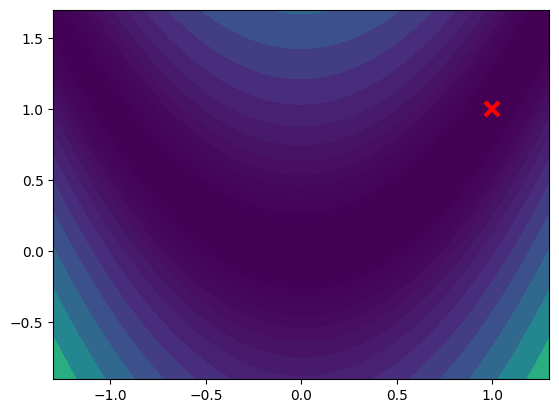

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2

X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [35]:
def objective(trial):
    x=trial.suggest_float("x",-2,2)
    y=trial.suggest_float("y",-2,2)
    return(1-x)**2+100*(y-x**2)**2

the trail.suggest_float object specifis the parameter tranges to smaple uniformly from
Optuna also provides suggest_int and suggest_categorial for integer and categorical parameters, respectively.

- Optuna collects multiple trials as a study, so to create one we just pass the. objective() function to study.optimize()

In [36]:
!pip install optuna -q

In [37]:
import optuna

study=optuna.create_study()
study.optimize(objective,n_trials=1000)

[I 2023-09-04 15:21:13,604] A new study created in memory with name: no-name-25814068-00a5-48e6-a39f-fc516132f089
[I 2023-09-04 15:21:13,607] Trial 0 finished with value: 1500.9350679507747 and parameters: {'x': 1.933482698245769, 'y': -0.13471020886741014}. Best is trial 0 with value: 1500.9350679507747.
[I 2023-09-04 15:21:13,610] Trial 1 finished with value: 7.164735345972662 and parameters: {'x': 1.2252967884207697, 'y': 1.768072610818869}. Best is trial 1 with value: 7.164735345972662.
[I 2023-09-04 15:21:13,612] Trial 2 finished with value: 4.359250647400001 and parameters: {'x': 1.0704705112883879, 'y': 1.3545763407351932}. Best is trial 2 with value: 4.359250647400001.
[I 2023-09-04 15:21:13,614] Trial 3 finished with value: 542.5616119020785 and parameters: {'x': -1.5213524554560003, 'y': -0.0010954679159498326}. Best is trial 2 with value: 4.359250647400001.
[I 2023-09-04 15:21:13,616] Trial 4 finished with value: 33.51592416947972 and parameters: {'x': 1.378330391866145, 'y'

In [38]:
study.best_params

{'x': 1.0411555347151862, 'y': 1.081004776563245}

- We use similar logic by first defining the hyperpararmeter space that we wish to optimize over
- In addition to α and T, we'lll include the number of training epochs as follows:

In [39]:
def hp_space(trial):
    return {"num_train_epochs":trial.suggest_int("num_train_epochs",5,10),
            'alpha':trial.suggest_float('alpha',0,1),
            'temperature':trial.suggest_int('temperature',2,20)}

- Running the hyperparameter search with the Trainer is then quite simple; we just need to specify the number of trials to run and a direction ='maximize' in the hyperparameter search space as follows:

In [ ]:
best_run=distilbert_trainer.hyperparameter_search(n_trials=20,direction='maximize',hp_space=hp_space)

The hyperparameter_search() method returns a BestRun object, which contains the value of the objetive that was maximized (by default, the sum of all metrics) and the hyperparameters it use for that run

In [ ]:
print(best_run)

This value of α tells us that most of the training signal is coming from the knowledge distillation term.

In [48]:
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=distilled_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=10, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=0.12468168730193585,temperature=7, weight_decay=0.01,
    push_to_hub=True)


# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.577107,0.725806
2,0.761100,0.284280,0.884516
3,0.761100,0.178040,0.926129
4,0.279400,0.138144,0.930968
5,0.159800,0.120725,0.933548
6,0.159800,0.111901,0.938387
7,0.124400,0.106377,0.940968
8,0.110400,0.102678,0.941290
9,0.110400,0.100602,0.941613
10,0.103800,0.100068,0.940968


In [49]:
distil_trainer.push_to_hub("Training complete")


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

'https://huggingface.co/ckandemir/distilbert-base-uncased-distilled-clinc/tree/main/'

In [50]:

distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())


MOdel size (MB)- 255.88
Average latnecy(ms) - 9.90 +\- 1.00
Accuracy on test set - 0.868


<ipython-input-33-fff7e5c31a7e>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


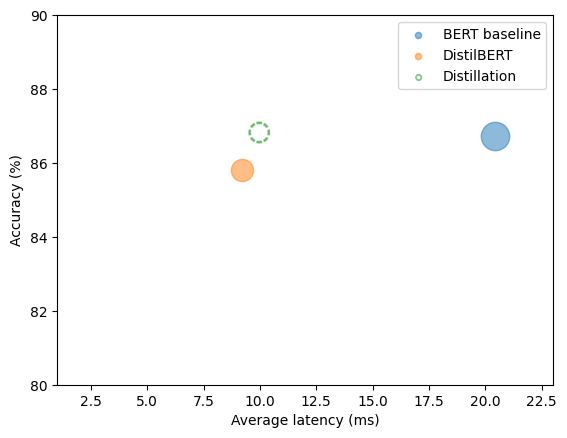

In [51]:
plot_metrics(perf_metrics, optim_type)


- We surpassed the performance of the teacher
- We can even further imporve this using quantization

## Making Models Faster with Quantization

- Instead of reducing the number of computations, it makes them muhc more efficient by representing the weights and activations with low-precision data types like 8bit integer INT8 instead of the usual 32-bit floating (FP32)

- Reducint the number of bnits means the resulting model requires less memory storage, and operations like matrix multiplication can be performed much faster with integer arithmetic.

- Remarkably these performance gains can be realized with little ot no loss in accuracy

- Basic idea behind quantization is that we can discretize the floating-point values f in each tensor by mapping their range [f_max,f_min] into smaller one [q_max,q_min]  of fixed point numbers q, and linearly distributing all values in between

Mathemathically ,this mapping is described as:


f=(f_max-f_min)/(q_max-q_min)(q-Z)=S(q-Z)

where the scale factor S is a positive floating point number and the constant Z has the same type as q and is called the zero point because it corresponds to the quantized value of the floating point value f=0

Map needs to be affine to we get back floating numbers when we dequantize the fixed-point ones




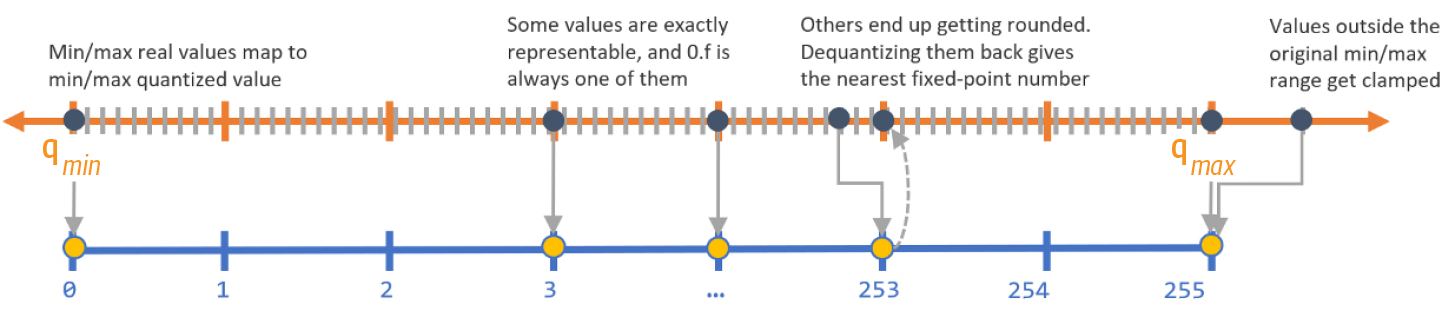

#### Quantizing floating point numbers as unsigned 8-bit integers

- One of the main reason why transformers(and depp neural networks more generally) are prime candidates for quantization is that the weights and activations tend to take values is relatively small ranges

- This means we dont hae to squeeze the whole range of possible FP32 numbers into, say the 2^8=256 numbers represented by INt8

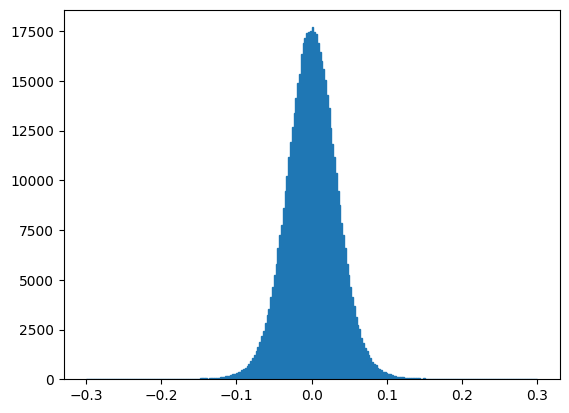

In [52]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

- As we can see the values of the weights are distributed in he small range [-0.1,0.1] around zero.

    - Now, suppose we want to quantize this tensor as a signed 8-bit integer. In that case, the range of possible values for our integers is [q_max,q_min]=[-128,127]

    - The zero point coincides with the zero of FP32 and the scale factor is calcualted according to the previous equation:

In [53]:
zero_point=0
scale=(weights.max()-weights.min())/(127-(-128))

- To obtain the quantized tensor, we just need to inbert the mapping q=f/S+Z, clamp the values, round them to the neares integer, and represent the resul in the torch.int8 data type using the Tensor.char() function:

In [54]:
(weights/scale+zero_point).clamp(-128,127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

### Great we've just qunatized our first tensor!. In PyTorch we can simplify the conversion by using the quantize_per_tensor() function together with a quantized data type, torch qint, that is optimized for integer arithemetic operations:

In [55]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

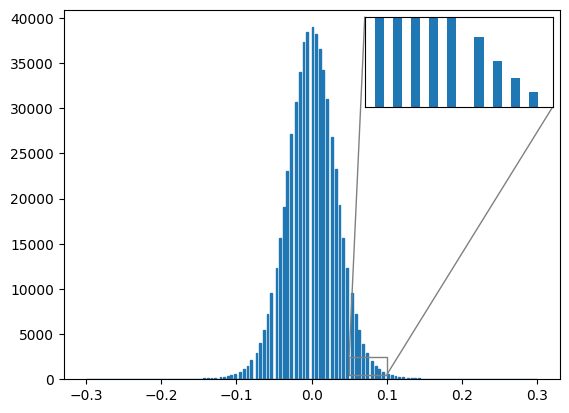

In [56]:

#hide_input
#id weight-quantization
#alt Effect of quantization on a transformer's weights
#caption Effect of quantization on a transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()


In [57]:
%%timeit
weights @ weights

1.07 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [58]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [59]:

%%timeit
q_fn.mul(quantized_weights, quantized_weights)

260 µs ± 4.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


- Quantization reduces the memory storage requirements by up to a factor of four In our simple  we can verify this by comparin th underlying storage size of our weights tensor and its quantized cousin by using th Tensor.storage() function and the getsizeof() functiom from pythons sys module

In [60]:

import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-60-600687c2638a>:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

For a full-scale transformer the actual compression rate depedns on whcih layers are quantized(it is only the linear layer that typically get quantized)

- For deep neural networks there are typically three main approaches to quantization:

- Dynamic quantization
    - When using dynamic quantization nothing is changed during training and the adpatations are only performed during inference.
    - The weights are converted to INT8 ahead of inference time.
    - Models activations are also quantized
    - All matrix multiplcations can be calculated with hogly optimized INT8 functions
    - Simplest one,however the activations are written and read to memory in floating -point format
    - This conversion between integer and floating point can be a performance bottleneck

- Static quantization
    - Instead of computing the quantization of the activations on the fly, we can avoid the conversion to floating point by precomputing the quantization scheme. Static quantization achiieves this by observing the activation patterns on a representative sample of the data ahead of inference time.
    - The ideal quantization scheem is calculated and then saved
    - this enables us to skip the convesion between int8 and fp32 values and speeds up the computations
    - However, it requires access to a good data sample and introduces an additional step int he pipeline since we now need to train and determine the quantization scheme before we can perform inference
    - there is also one aspect that static quantization does not address the discrepancy between the precision during trainign and inference lead to a performance drop in the models metrics(e.g. accuracy)

- Quantization-aware training
    - The effect of qunatization can be effectively simualted during trainng by fake quantizationn of the FP32 values.
    - Instead of using INT8 values during training the FP32 valeus are rounded to mimic the effect of quantization
    - This is done during both the forward and the backward pass and improves performacne in terms of mdooel metrics over static and dynamic quantization





Main bottleneck for running inference with transformers is the compute and memory bandwith associated with enormours number of weights in these models

- For this reason **dynamic quantization** is currently the best approach for **transformer-based models in NLP**

- In smaller computer vision models the limiting factor is the memory bandwith of the activations which why **static quantization** is generally used ( or quantization-aware training in cases where the performance drops are too signifacant)

In [24]:
##Dynamic Quantization
from torch.quantization import quantize_dynamic
from transformers import AutoModelForSequenceClassification
import torch
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [25]:

pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())


NameError: ignored

<ipython-input-33-fff7e5c31a7e>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


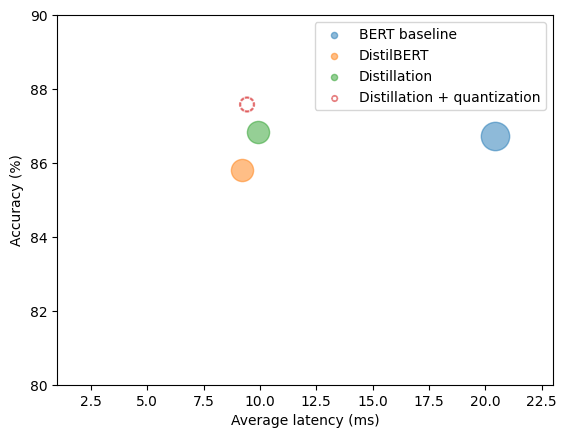

In [64]:
plot_metrics(perf_metrics, optim_type)


- A good practice is to pick the lowest precision that you can tolerate with respect to your evaluation metrics
- We'll use INT8 and see has little impact on our models accuracy


##Optimizin Inference with ONNX and the ONNX Runtime

- ONNX is an open standard that defines a common set of operators and a common file format to represent deep learning models in a wide variety of frameworks, including PyTorch and TensorFlow.

- When a model is exported to the ONNX format, these opperators are used to construct a computational grpah (often called called an intermediate representation) that represents the flow of data throguht the neural network



<ipython-input-33-fff7e5c31a7e>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


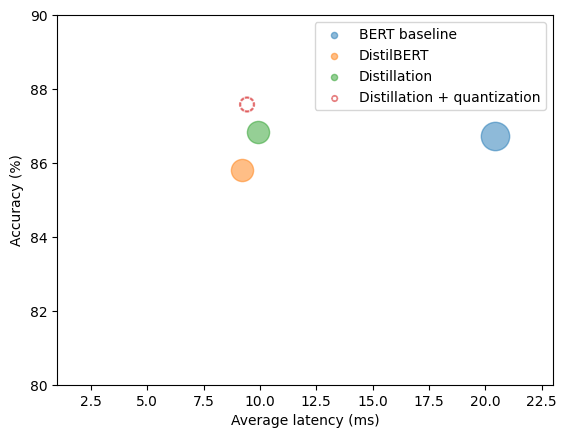

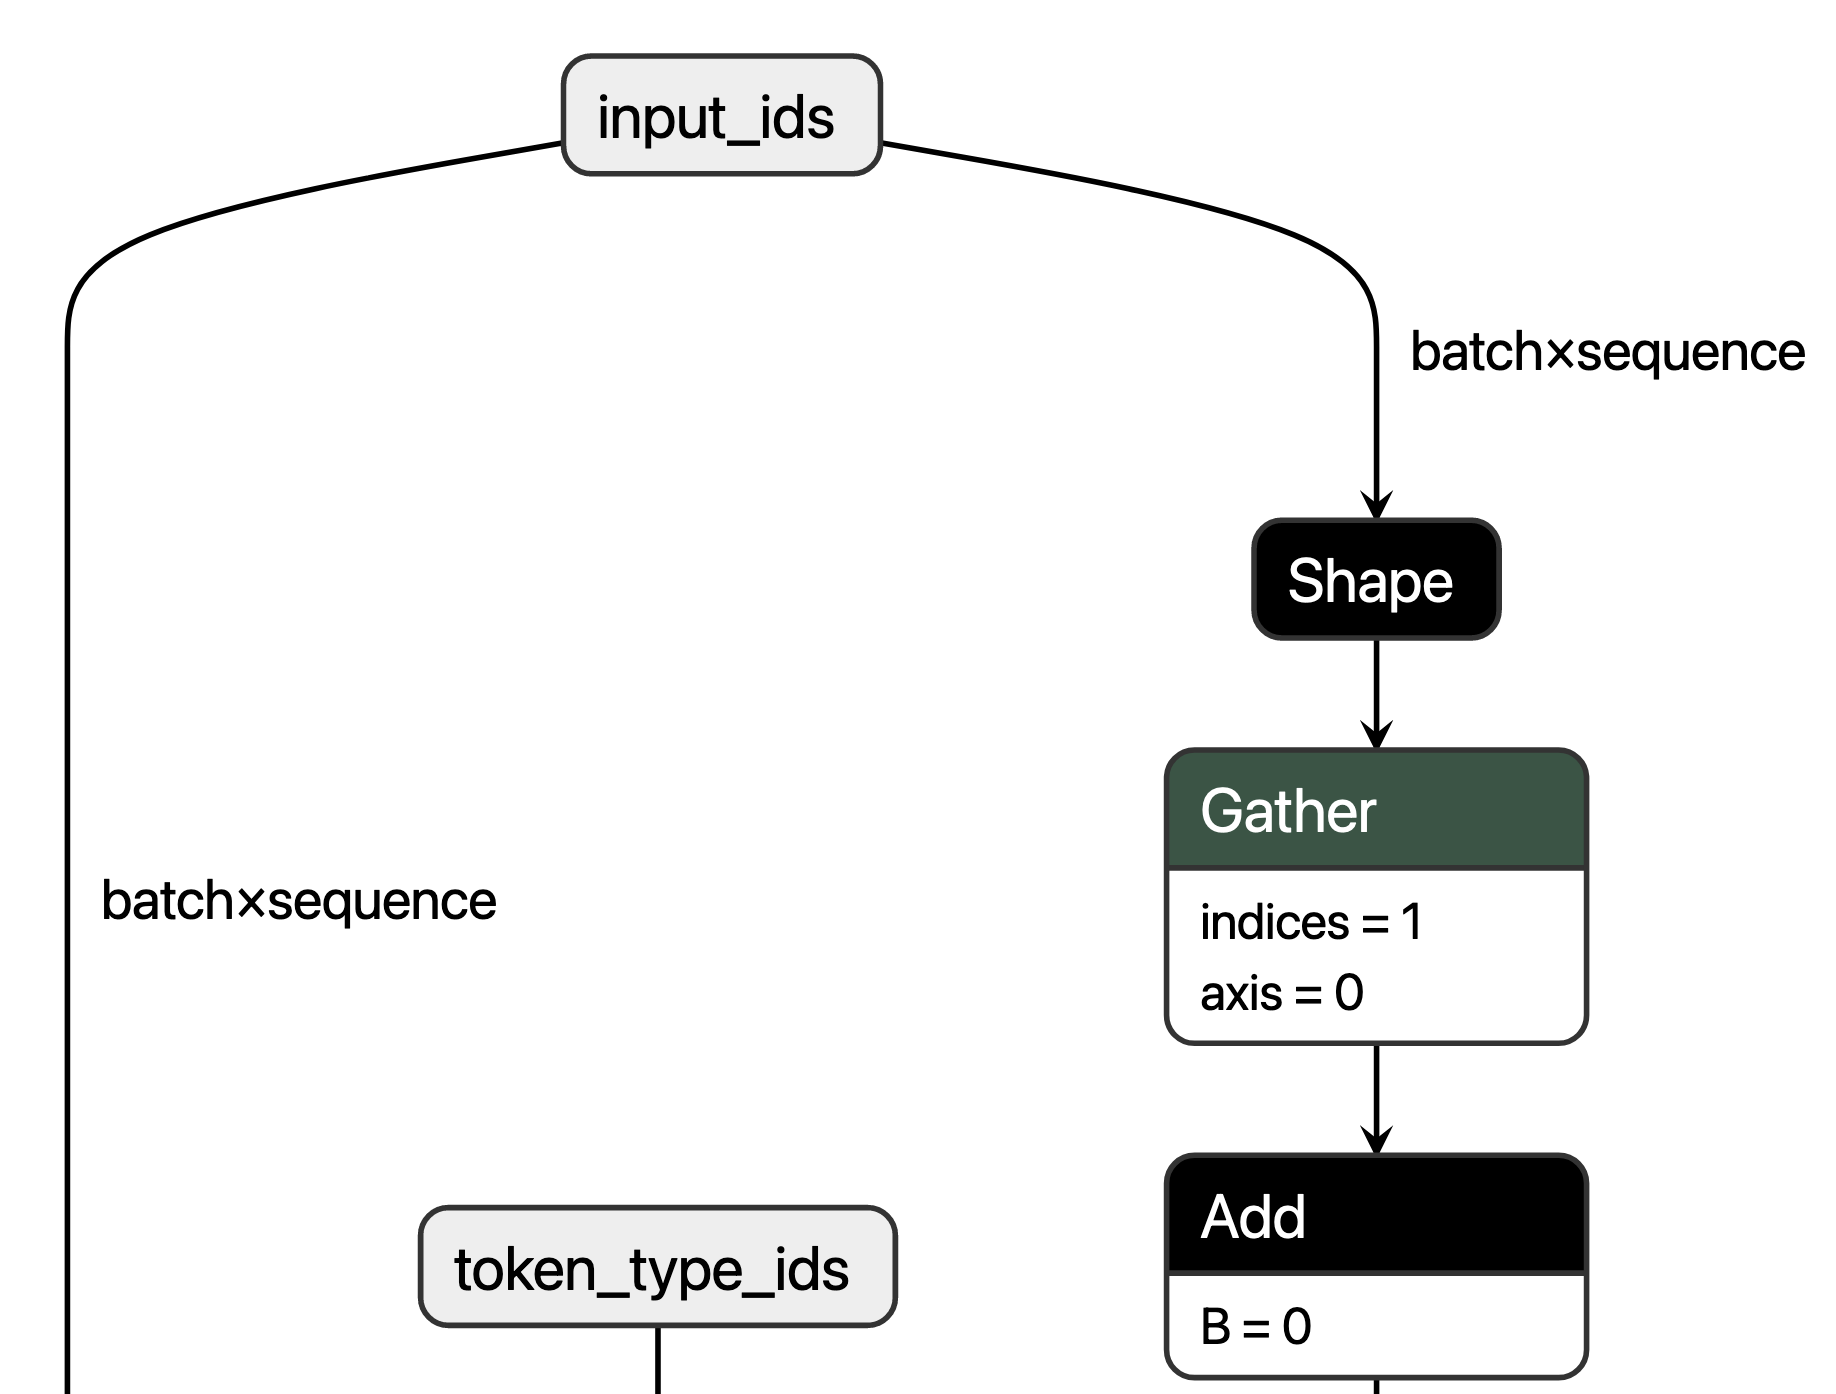

By exposing a graph with standardized operators and data types ONNX makes it easy to swithc between frameworks
- A model trained on PyTorch can be exported to ONNX fromat and then imported in Tensorflow( viceversa)

- ONNX Runtime provides tools to optimze the ONNX graph through techniques like:
    - operator fusion
        - A fused operations involves mergin one operator (usually an activation function) into another so that they can be executed tohether
        - Suppose we want to apply an activation f to a matrix product A x B. Normally the result of the product needs to be written back tot he GPU memory before the activation is computed. Operator fussion allow as to compute f(AxB) ina single step.
    - constant folding
        -  Refers to th eprocess of evaluating constant expressions at compile time instead of runtime


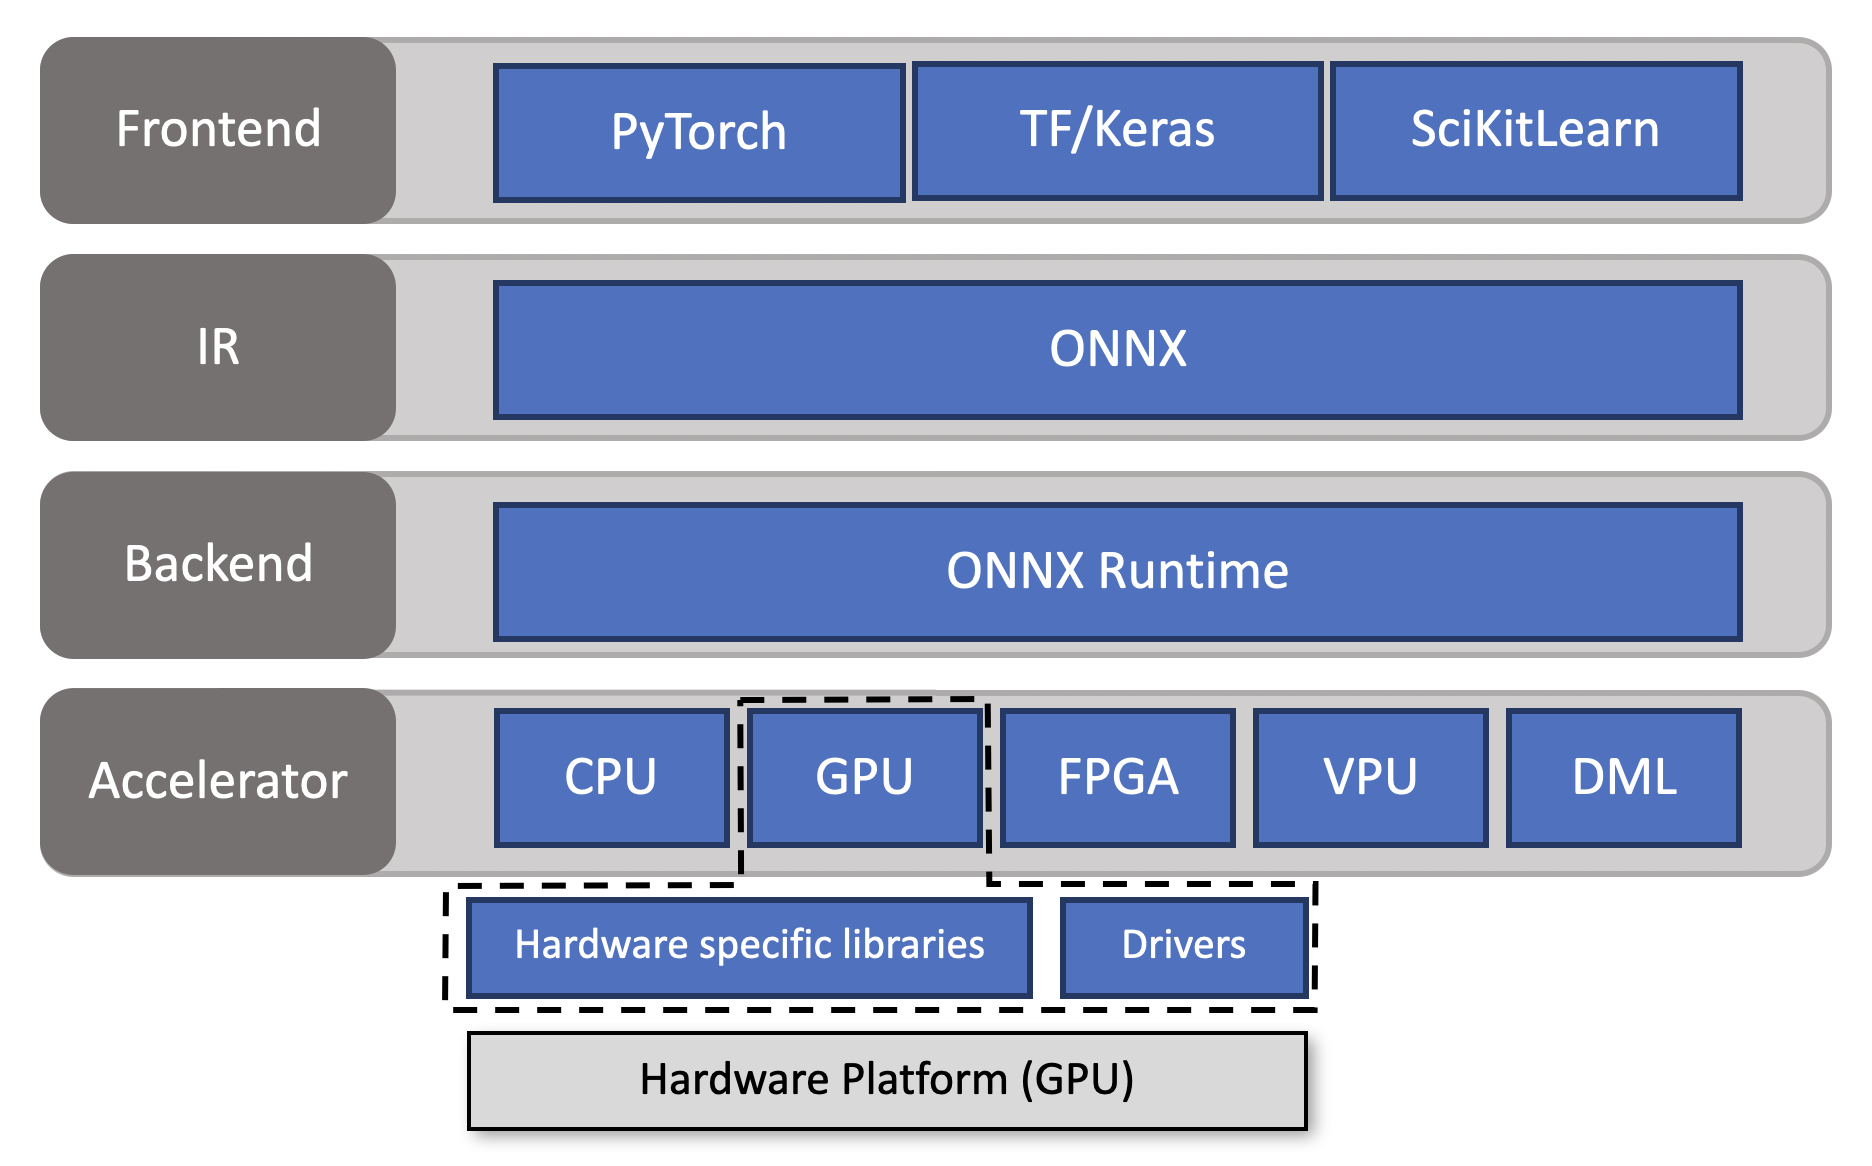

## Architecture of the ONNX and ONNX runtime exosytem

To see ORT in action, the first thing we need to do is conver out distilled model into ONNX format



In [65]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [1]:
pip install --upgrade onnx


In [21]:
from transformers.convert_graph_to_onnx import convert
from pathlib import Path

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

NameError: ignored

ONNX uses operator sets to group  together immutable operator specifications, so opset=12 corresponds to a specific version of the ONNX library

In [ ]:

from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session
onnx_model = create_model_for_provider(onnx_model_path)

- We get the class logits from the ONNX model
- Since the output from ocnvert() tells use that ONNX expects the input_ids and attention _mask as inputs, we need to drop the label column from our sample:

In [ ]:

inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape


Once we have the logits, we can easily get the predicted label by taking the argmax:

In [ ]:
np.argmax(logits_onnx)


In [ ]:
clinc_enc["test"][0]["labels"]


The ONNX model is not compatible witht he text-classification pipeline so we'll create our own class that mimics the core behavior:

In [ ]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self,model,tokenizer):
        self.model=model
        self.tokenizer=tokenizer

    def __call__(self,query):
        model_input=self.tokenizer(query,return_tensors='pt')
        inputs_onnx={k:v.cpu().detach().numpy(
            for k, v in model)inputs.items()}
        logits=self.model.run(None,inputs_onnx)[0][0,:]
        probs=softmax(logits)
        pred_idx=np.argmax(probs).items()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]


We can the test this on our simple queyr to see if we can recover the car_rental intent:

In [ ]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [ ]:

optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)


Converting to the ONNX format and using th eONNX Runtime has given our distilled model a boost in latency

In [ ]:

from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [ ]:

onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())


In [ ]:
plot_metrics(perf_metrics, optim_type)


- ORT quantization has reduced the model size and latency by around .3 compared to the model obtained from PyTorch qunatization (the distilattion + quantization)
- One reason for this si that PyTorch only optimizes the nn.Linear modules while ONNX quantizes the embedding layer as well

## Making Models Sparser with Weight Pruning


- If we need to deply on a mobile device, then we'll need our intent nclassifier to take up as little storage space as possible
- We can shrink the number of paramters in our model by identifying and removing the lesast important weights in the network


### Sparsity in DEep Neural Networks

- The main idea behind pruning is to gradually remove weight connections and potentially neurons during training such that the model becomes progressively sparser
- The resulting pruned model has a smaller number of nonzero parameters, whcih can the be stored in a compat sparse matrix format

- Pruning can also combined with quantization to obtain further compression


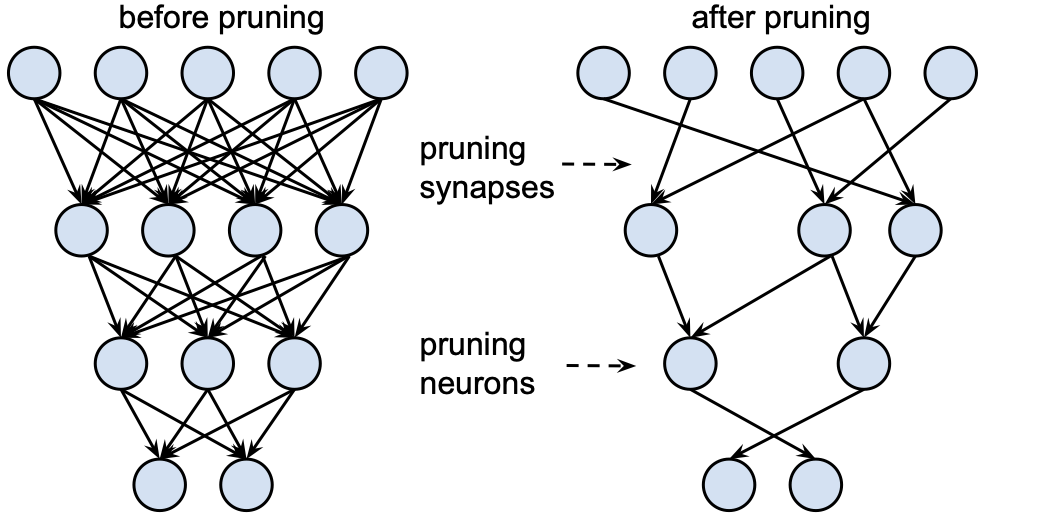

Weight Pruning Methods
- We calculate a matrix S of importance scores and then select ht top k percent of weights by importance

Topₖ(S)ᵢⱼ={1 if Sᵢⱼ in top k%  ,  0 otherwise


- In effect, k acts as a new hyperpararmeter to contrul the amoun of sparsity in the model - that is, the propertion of weights that are zero values. Lower values of k correspond to sparser matrices
- From these scores we can then define a mask matrix M that masks the weights Wᵢⱼ during the forward pass with some input xᵢ and effectively creates a sparse network of activations :

aᵢ=ΣₖWᵢₖMᵢₖxₖ



## Magnitude Pruning
- Calculates the scores based on the magnitude of the weights S=(|Wᵢⱼ|)_1<j, j<n and then derives the masks form M=Topₖ
- In literature we apply magnitude pruning in an iterative fashinon by first training the model to learn which connections are important and pruning the weights of least importance
- The sparse model is tehn retrained and the process repated untthe desried sparsity is reached

- Drawback: Computationally expansive.
 - Problem : it is designed for pure supervised learning, where the importance of each weight is directly related to the task at ahnd
 - By contrast, trqansfer learning the importance of the weights is primarily determined by the pretraining phase, so magnintude pruning can remove connections that are important for the fine tuning task


## Movement Pruning
- Gradulally remove weights druing finetuning sucha tht the model becomes progressively sparser
- The key novelty here the weights adn the sores are learned during fine-tuning
- So instead of bein derived directly from the wegiths. (like magnitude pruning) **the scores in movement pruning are arbitrary and are learned through gradient descent like any other neural network parameter**

- This implies that in the backward pass, we also track the gradient of the loss L with respect o the scores Sᵢⱼ
- The weights that are moving the most from zero are the most important ones to keep
    - Positive weights increase during fine-tuning (vice versa for negative weights)
    - Equal to saying that scores increase as the weights move away from zero
- Hugging Face, weights move from zero to + more are the important ones, treat scores as parameters watch the weights as score goes up cut the ones that dont move  as much